# SVB surface test script

This script demonstrates SVB running 'on the surface' to infer the parameters of a single exponential decay signal model. 

Voxel-wise data is generated with a given amplitude, decay rate and noise SD. Each voxel in the volume is an independent time series of samples. Although they all share the same underlying signal parameters, the additive zero-mean (aka white) noise present in each one will be different. 

A spherical surface is then generated to intersect the voxel grid (note that many voxels will not intersect the surface and are therefore discarded). Multiple surface vertices may be present in each voxel, leading to an under-determined system. The SVB framework is used to infer the signal parameters at each vertex *on the surface* using the data generated in *volume space*. The process is run both with and without the spatial prior to illustrate how this is helpful in an under-determined system. 

In [1]:
%load_ext autoreload 
%autoreload 2

import sys 
import numpy as np
import matplotlib.pyplot as plt
import toblerone as tob 
import regtricks as rt
import trimesh
from svb.main import run
import pyvista as pv 
from pyvista import PlotterITK
from svb.models.asl import AslRestModel 
from svb.data import SurfaceModel

try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf

# To make tests repeatable
tf.set_random_seed(1)
np.random.seed(1)

Instructions for updating:
non-resource variables are not supported in the long term


Generate a cubic voxel grid of data. The model parameters for the exponential case are amplitude and decay rate, and the noise is zero-mean with a given SD (aka white noise). Multiple samples are taken from the exponential curve to produce a 4D dataset (X,Y,Z,T)

In [2]:
sq_len = 10 
vox_size = 2
ref_spc = rt.ImageSpace.create_axis_aligned(np.zeros(3), 3 * [sq_len], 3 * [vox_size])
bounding_box = np.array([ref_spc.bbox_origin, ref_spc.bbox_origin + ref_spc.fov_size])
bounding_box = np.meshgrid(*[ se for se in bounding_box.T ])
ref_spc

ImageSpace with properties:
size:          [  10.000   10.000   10.000], 
voxel size:    [   2.000    2.000    2.000], 
field of view: [  20.000   20.000   20.000],
vox2world:     [   2.000    0.000    0.000    1.000]
               [   0.000    2.000    0.000    1.000]
               [   0.000    0.000    2.000    1.000]
               [   0.000    0.000    0.000    1.000]
loaded from: (no direct file counterpart)

Create a reference voxel grid for the data 


In [3]:
ctx_thickness = 1
out_r = ((sq_len * vox_size) - 1) / 2
in_r = out_r - ctx_thickness
mid_r = out_r - (ctx_thickness / 2)
mesh = trimesh.creation.icosphere(2, 1)
shift = 1.5 * (np.random.rand(*mesh.vertices.shape) - 0.5)
orig = (ref_spc.fov_size / 2)

out_surf = tob.Surface.manual((out_r * mesh.vertices) + orig + shift, mesh.faces)
in_surf = tob.Surface.manual((in_r * mesh.vertices) + orig + shift, mesh.faces)
mid_surf = tob.Surface.manual((mid_r * mesh.vertices) + orig + shift, mesh.faces)

print(mid_surf)
mid_edges = mid_surf.edges()
vertex_dist = np.linalg.norm(mid_edges, axis=-1).reshape(-1,3).mean()
print("Mean vertex spacing on midsurface {:.2f}mm".format(vertex_dist))

Surface with 162 points and 320 triangles. 
min (X,Y,Z):  [0.6193166  0.6205257  0.45621204]
mean (X,Y,Z): [ 9.961548 10.069835 10.002049]
max (X,Y,Z):  [19.60507  19.501938 19.114576]

Mean vertex spacing on midsurface 2.84mm


Plot the cortical outer surface within the reference voxel grid to check it is fully contained. 

In [4]:
# plot = PlotterITK()
# v = pv.StructuredGrid(*bounding_box)
# plot.add_mesh(v, opacity=0.3)
# plot.add_mesh(out_surf.to_polydata(), color='tan')
# plot.show()

Initialise the projector that will be used to map data from the surface into the volume. This incorporates PV weighting, so the ground truth data that we provide to the SVB fit must include PV effects. 

In [5]:
hemi = tob.Hemisphere.manual(in_surf, out_surf, 'L')
projector = tob.projection.Projector(hemi, ref_spc)
projector.surf2vol_matrix().shape

Initialising projector (will take some time)
L cortex in: 100%|########## 00:15 | 00:00
L cortex out: 100%|########## 00:17 | 00:00


(1000, 162)

Generate a mask of voxels that do not intersect the cortex. Calculate the mean number of vertices per voxel for those that do intersect. A cortical surface at 32k resolution in a voxel grid of ~3mm iso has around 10 vertices per voxel. 

In [6]:
vertices_per_voxel = (projector.surf2vol_matrix() > 0).sum(1).A.flatten()
vol_mask = (vertices_per_voxel > 0)
surf2vol_weights = projector.surf2vol_matrix()[vol_mask,:]
print("Mean vertices per voxel:", (surf2vol_weights > 0).sum(1).mean())

Mean vertices per voxel: 6.084033613445378


Apply the PV weighting to the data and add noise *afterwards*. The assumption is that noise is a random process that is not related to the amount of tissue present in a voxel. Plot the PV map and the final simulated data. 

In [18]:
plds = np.arange(0.25, 1.75, 0.25)
repeats = 10
data = np.zeros(3*[sq_len] + [ repeats * plds.size ])
surf_model = SurfaceModel(data, surfaces={'LMS': mid_surf}, projector=projector, mask=vol_mask)
asl_model = AslRestModel(surf_model, plds=plds, repeats=repeats, casl=True) 
tpts = asl_model.tpts()

Data voxels: 476


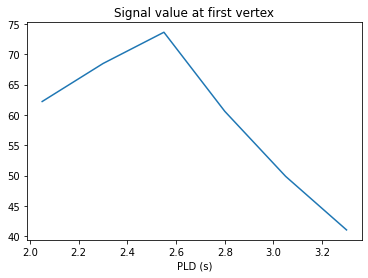

In [19]:
CBF = 60 
ATT = 0.75
NOISE_VAR = 0.0

ftiss = CBF * np.ones([surf_model.n_nodes, tpts.size], dtype=np.float32)
deltiss = ATT * np.ones([surf_model.n_nodes, tpts.size], dtype=np.float32)

sess = tf.Session()
surf_data = sess.run(asl_model.evaluate([ftiss, deltiss], tpts))
sess.close()

fig = plt.figure()
plt.plot(tpts, surf_data[0,:])
plt.title('Signal value at first vertex')
plt.xlabel('PLD (s)')
plt.show()

In [20]:
vol_data = projector.surf2vol(surf_data)
vol_data += np.random.normal(0, NOISE_VAR, vol_data.shape)
pvs = projector.flat_pvs()
vox_idx = np.argmax(pvs[:,0])

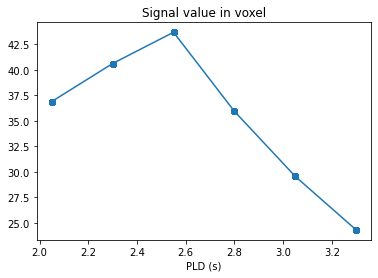

In [21]:
fig = plt.figure()
plt.scatter(tpts, vol_data[vox_idx,:])
plt.plot(plds + asl_model.tau, vol_data[vox_idx,:].reshape(len(plds),-1).mean(1))
plt.title('Signal value in voxel')
plt.xlabel('PLD (s)')
plt.show()

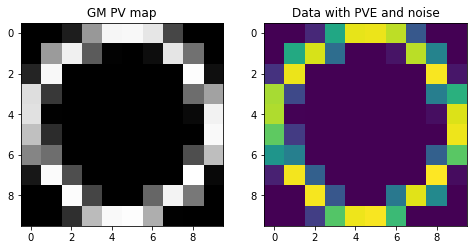

In [22]:
vol_data = vol_data.reshape(*ref_spc.size, tpts.size)

plt.figure(figsize=(8,4))
slc = ref_spc.size[2] // 2 
plt.subplot(1,2,1)
plt.title('GM PV map')
plt.imshow(pvs.reshape(*ref_spc.size, -1)[:,:,slc,0], cmap='gist_gray')
plt.subplot(1,2,2)
plt.title('Data with PVE and noise')
plt.imshow(vol_data[:,:,slc,0])
plt.show()

Plot the surface to volume projection matrix

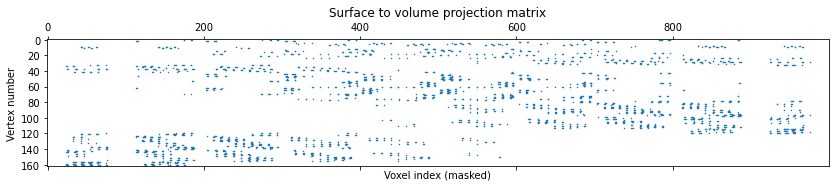

In [23]:
plt.figure(figsize=(14,5))
plt.spy(projector.surf2vol_matrix().T, markersize=0.5)
plt.title('Surface to volume projection matrix')
plt.ylabel('Vertex number')
plt.xlabel('Voxel index (masked)')
plt.show()

In [24]:
# Fit options common to both runs 
options = {
    "learning_rate" : 0.005,
    "batch_size" : plds.size,
    "sample_size" : 5,
    "epochs" : 1000,
    "log_stream" : sys.stdout,
    "prior_type": "N",
    "mask" : vol_mask,
    "projector" : projector,
    "surfaces" : { 'LMS': mid_surf }, 
    "plds": plds, 
    "repeats": repeats, 
    "casl": True, 
}

# # Fit all parameters in N mode: no spatial prior, ie independent voxel fit 
# runtime_n, svb_n, training_history_n = run(
#     vol_data, "asl", 
#     "surf_asl_out", 
#     **options)

# Fit amp1 and r1 in M mode: spatial prior 
raise RuntimeError("M spatial prior causing numerical instability")
runtime, svb, training_history = run(
    vol_data, "asl", 
    "surf_asl_out_M", 
    param_overrides={
        "ftiss" : { "prior_type": "M" }, 
        "deltiss" : { "prior_type": "M" }
    },
    **options)


2097] noise mean/var=[3.00702   1.0267177] lr=0.005000, ss=10 - Saving
INFO :  - Epoch 0382: mean/median cost=-659444205166.915771/-251518866390.359558 (latent=-659444205175.805176, reconstr=8.889357) param means=[73.25863   0.704038] param vars=[0.00089086 0.00091912] noise mean/var=[3.0185854 1.0269163] lr=0.005000, ss=10 - Saving
INFO :  - Epoch 0383: mean/median cost=-899956939286.546997/-340396530646.412354 (latent=-899956939295.315063, reconstr=8.768089) param means=[73.54182     0.70358217] param vars=[0.0008738 0.0009174] noise mean/var=[3.032026  1.0271307] lr=0.005000, ss=10 - Saving
INFO :  - Epoch 0384: mean/median cost=-1228138810090.392334/-461530914774.833679 (latent=-1228138810099.071533, reconstr=8.679107) param means=[73.82774   0.704698] param vars=[0.00084889 0.0009157 ] noise mean/var=[3.0471516 1.0273478] lr=0.005000, ss=10 - Saving
INFO :  - Epoch 0385: mean/median cost=-1676387094591.849854/-617209167830.830933 (latent=-1676387094600.408203, reconstr=8.558233) p

KeyboardInterrupt: 

In [13]:
amp_n, decay_n = svb_n.evaluate(svb_n.model_means)
noise_n = svb_n.evaluate(svb_n.noise_mean)

amp, decay = svb.evaluate(svb.model_means)
noise = svb.evaluate(svb.noise_mean)
amp_var, decay_var = svb.evaluate(svb.model_vars)

In [14]:
plot = PlotterITK()
plot.add_mesh(mid_surf.to_polydata(), scalars=amp)
plot.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Plot vertex- (model) and voxel-wise (noise) parameter means. N refers to non-spatial estimation, M is spatial. As expected, M reduces the variance in estimated parameter means for the model parameter, and has little effect on noise (because the only the *model* priors were set as M, not the noise itself). 

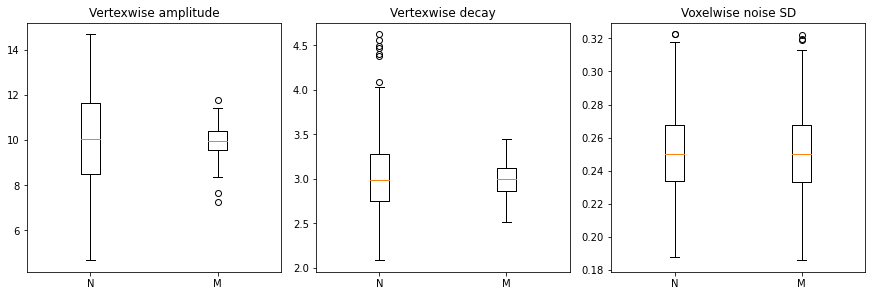

In [15]:
fig, axes = plt.subplots(1,3, constrained_layout=True)
fig.set_size_inches(12,4)
axes[0].set_title('Vertexwise amplitude')
axes[0].boxplot([amp_n, amp], labels=['N', 'M'])
axes[1].set_title('Vertexwise decay')
axes[1].boxplot([decay_n, decay], labels=['N', 'M'])
axes[2].set_title('Voxelwise noise SD')
axes[2].boxplot([noise, noise_n], labels=['N', 'M'])
plt.show()

**The following analysis is restricted to the M outputs only**

Plot vertex-wise parameter mean and variance against each other. There seems to be a small negative correlation in amplitude; no notable pattern in decay. 

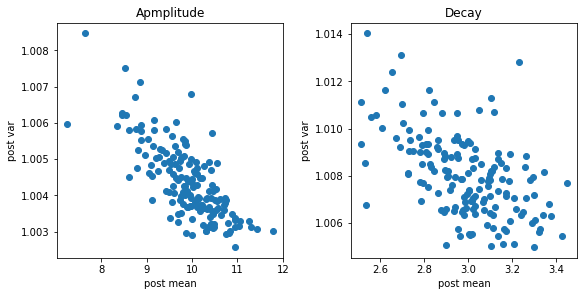

In [16]:
fig, axes = plt.subplots(1,2, constrained_layout=True)
fig.set_size_inches(8,4)
axes[0].scatter(amp, amp_var)
axes[1].scatter(decay, decay_var)
for idx,title in enumerate(['Apmplitude', 'Decay']):
    axes[idx].set_title(title)
    axes[idx].set_xlabel('post mean')
    axes[idx].set_ylabel('post var')

Plot vertexwise parameter means against each other. During the SVB run, the two model parameters were assumed to be independent of each other. A positive correlation is seen between amplitude and decay (why?). 

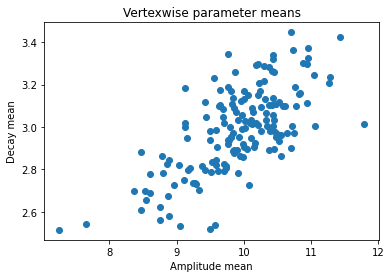

In [17]:
plt.scatter(amp, decay)
plt.title('Vertexwise parameter means')
plt.xlabel('Amplitude mean')
plt.ylabel('Decay mean')
plt.show()

Plot vertexwise parameter means against the PV of the voxel that the vertex associates to most strongly. This information is extracted from the projection matrix. Although a vertex can contribute to multiple voxels, we pick the one to which it contributes the most weight. One important aspect of surface SVB is that PVE are implicitly accounted for during the estimation process via the projection matrix. Hence, we should not see a corrrelation between voxel PV and estimated parameter means, and this does seem to be the case. 

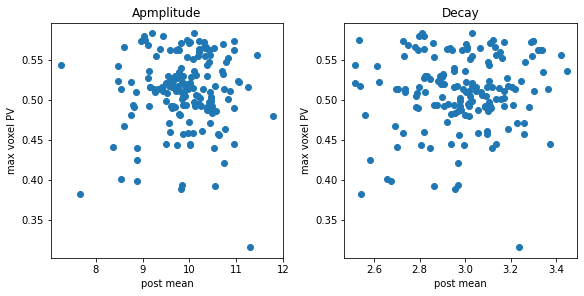

In [18]:
maxvox_inds = projector.surf2vol_matrix().argmax(0).A.flatten()
maxvox_pvs = projector.flat_pvs()[maxvox_inds,0]
fig, axes = plt.subplots(1,2, constrained_layout=True)
fig.set_size_inches(8,4)
axes[0].scatter(amp, maxvox_pvs)
axes[1].scatter(decay, maxvox_pvs)
for idx,title in enumerate(['Apmplitude', 'Decay']):
    axes[idx].set_title(title)
    axes[idx].set_xlabel('post mean')
    axes[idx].set_ylabel('max voxel PV')

Plot vertexwise parameter variances against the PV of the voxel that the vertex associates to most strongly. Based on the plot, it would seem that lower voxel PVs do not correlate with increased parameter uncertainty. 

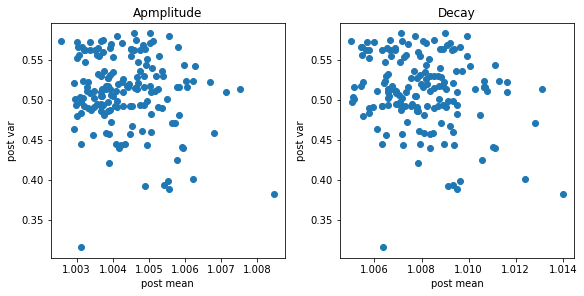

In [19]:
maxvox_inds = projector.surf2vol_matrix().argmax(0).A.flatten()
maxvox_pvs = projector.flat_pvs()[maxvox_inds,0]
fig, axes = plt.subplots(1,2, constrained_layout=True)
fig.set_size_inches(8,4)
axes[0].scatter(amp_var, maxvox_pvs)
axes[1].scatter(decay_var, maxvox_pvs)
for idx,title in enumerate(['Apmplitude', 'Decay']):
    axes[idx].set_title(title)
    axes[idx].set_xlabel('post mean')
    axes[idx].set_ylabel('post var')
plt.show()